<a href="https://colab.research.google.com/github/VVKate/Neural_University_HomeWorks/blob/main/5_%D0%A0%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%B8_%D0%BE%D0%B4%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%D0%BD%D1%8B%D0%B5_%D1%81%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнеее задание: Июльский курс (2020). Pro. Занятие 5
# Рекуррентные нейронные сети и одномерные свёрточные сети для обработки текстов
## Верхошинская Катерина Викторовна

## **LIGHT**


### **Задание:**

Используя шаблон ноутбука, напишите четыре нейронки для распознавания писателей. Для этого выполните следующее:
1. Загрузите данные и разделите на слова.
2. Создайте словарь и превратите данные в индексы.
3. Превратите данные в обучающую выборку.
4. Напишите нейронные сети.

Четыре нейронки, которые нужно написать:
1. Embedding + Dense сеть.
2. Embedding + LSTM сеть.
3. Embedding + Conv1D сеть.
4. Embedding + сложная сеть из Dense, LSTM и Conv1D.








In [ ]:
from google.colab import files
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
# Загружаем алгоритмы обучения/оптимизации
from tensorflow.python.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence #инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split #модуль для разбиения данных на обучающую и тестовую выборки

In [ ]:
!rm -R /content/texts 
!unzip -q '/content/drive/My Drive/Colab Notebooks/Базы/Тексты писателей.zip' -d /content/texts 

rm: cannot remove '/content/texts': No such file or directory


In [ ]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        
  text = f.read()                
  text = text.replace("\n", " ") 
  
  return text                    

# Объявляем интересующие нас классы
className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] 
nClasses = len(className) 


#Загружаем обучающие тексты

trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

for i in className: 
  for j in os.listdir('texts/'): 
    if i in j: 
      if 'Обучающая' in j:
        trainText.append(readText('texts/' + j))
        print(j, 'добавлен в обучающую выборку') 
      if 'Тестовая' in j:
        testText.append(readText('texts/' + j))
        print(j, 'добавлен в тестовую выборку')
  print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку



In [ ]:
# Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью

maxWordsCount = 20000 # определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

# для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower=True, split=' ', char_level=False, oov_token = 'unknown')

tokenizer.fit_on_texts(trainText)
items = list(tokenizer.word_index.items())

In [ ]:
print(items[:100]) # взглянем на содержимое словаря

[('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('это', 13), ('но', 14), ('все', 15), ('у', 16), ('по', 17), ('его', 18), ('к', 19), ('так', 20), ('мне', 21), ('из', 22), ('за', 23), ('меня', 24), ('ты', 25), ('же', 26), ('сказал', 27), ('бы', 28), ('было', 29), ('вы', 30), ('от', 31), ('они', 32), ('мы', 33), ('только', 34), ('да', 35), ('еще', 36), ('она', 37), ('о', 38), ('когда', 39), ('вот', 40), ('уже', 41), ('если', 42), ('был', 43), ('ни', 44), ('их', 45), ('нет', 46), ('чтобы', 47), ('до', 48), ('ну', 49), ('для', 50), ('ему', 51), ('может', 52), ('или', 53), ('ничего', 54), ('даже', 55), ('там', 56), ('очень', 57), ('кто', 58), ('ее', 59), ('тут', 60), ('потом', 61), ('просто', 62), ('него', 63), ('чем', 64), ('быть', 65), ('теперь', 66), ('под', 67), ('где', 68), ('нас', 69), ('есть', 70), ('тебя', 71), ('время', 72), ('ли', 73), ('тебе', 74), ('со', 75), ('во', 76), ('вас', 77), ('раз'

In [ ]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)   # проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1] [:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20])

print()
print()

print("Статистика по обучающим текстам:")
for i in range(6):
  print(className[i], " ", len(trainText[i]), " символов, ", len(trainWordIndexes[i]), " слов")
print("В сумме ", len(trainText[0])+len(trainText[1])+len(trainText[2])+len(trainText[3])+len(trainText[4])+len(trainText[5]), " символов, ", len(trainWordIndexes[0])+len(trainWordIndexes[1])+len(trainWordIndexes[2])+len(trainWordIndexes[3])+len(trainWordIndexes[4])+len(trainWordIndexes[5]), " слов")
print()
print("Статистика по обучающим текстам:")
for i in range(6):
  print(className[i], " ", len(testText[i]), " символов, ", len(testWordIndexes[i]), " слов")
print("В сумме ", len(testText[0])+len(testText[1])+len(testText[2])+len(testText[3])+len(testText[4])+len(testText[5]), " символов, ", len(testWordIndexes[0])+len(testWordIndexes[1])+len(testWordIndexes[2])+len(testWordIndexes[3])+len(testWordIndexes[4])+len(testWordIndexes[5]), " слов")

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал
Он же в виде последовательности индексов:  [470, 22, 1, 1482, 49, 2, 12725, 7723, 5, 415, 1, 4, 252, 2, 4, 247, 55, 6, 240, 10517]


Статистика по обучающим текстам:
О. Генри   1049517  символов,  160682  слов
Стругацкие   2042469  символов,  313405  слов
Булгаков   1765648  символов,  262109  слов
Саймак   1609507  символов,  251551  слов
Фрай   3700010  символов,  569052  слов
Брэдберри   1386454  символов,  214694  слов
В сумме  11553605  символов,  1771493  слов

Статистика по обучающим текстам:
О. Генри   349662  символов,  53255  слов
Стругацкие   704846  символов,  108730  слов
Булгаков   875042  символов,  132910  слов
Саймак   318811  символов,  50362  слов
Фрай   1278191  символов,  196911  слов
Брэдберри   868673  символов,  132746  слов
В сумме  4395225  символов,  674914  слов


In [ ]:
# Формирование обучающей выборки по листу индексов слов

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0

  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample

In [ ]:
# Формирование обучающей и проверочной выборки

def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

   # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) 
  classesXSamples = []        
  for wI in wordIndexes:      
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) 

  # Формируем один общий xSamples
  xSamples = [] 
  ySamples = []
  
  for t in range(nClasses):  
    xT = classesXSamples[t]  
    for i in range(len(xT)): 
      xSamples.append(xT[i])
    
    # Формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) 
    for i in range(len(xT)): 
      ySamples.append(currY) 

  # переводим в массив numpy для подачи в нейронку
  xSamples = np.array(xSamples) 
  ySamples = np.array(ySamples) 

  
  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

In [ ]:
# Задаём базовые параметры
xLen = 1000 # Длина отрезка текста, по которой анализируем, в словах
step = 100 # Шаг разбиения исходного текста на обучающие вектора

In [ ]:
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку

In [ ]:
# Представляем тестовую выборку в удобных для распознавания размерах

def createTestMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) 
  xTest6Classes01 = []               
  xTest6Classes = []                 
  for wI in wordIndexes:            
    sample = (getSetFromIndexes(wI, xLen, step)) 
    xTest6Classes.append(np.array(sample))      
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) 
  xTest6Classes01 = np.array(xTest6Classes01)                   
  
  return xTest6Classes01, xTest6Classes # функция вернёт тестовые данные


# Расспознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  val = []
  pred = []
  
  totalSumRec = []
  
  # Проходим по всем классам
  for i in range(nClasses):
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    currOut = np.argmax(currPred, axis=1)
    
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))
    
    totalSumRec.append(sumRec[i])
    
    # Определяем, какой в класс в итоге за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)
    
    # Выводим результаты распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)
  
  # Выводим вредний процент распознавания по всем классам вместе
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
  print()
  return sumVal/sumCount

xTest6Classes01, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step)

### Четыре нейронки, которые нужно написать:

* Embedding + Dense сеть.
* Embedding + LSTM сеть.
* Embedding + Conv1D сеть.
* Embedding + сложная сеть из Dense, LSTM и Conv1D.




#### 1. Embedding + Dense сеть.

Epoch 1/30
89/89 [==============================] - 155s 2s/step - loss: 1.2112 - accuracy: 0.5705 - val_loss: 5.4710 - val_accuracy: 0.2549
Epoch 2/30
89/89 [==============================] - 155s 2s/step - loss: 0.0300 - accuracy: 0.9923 - val_loss: 10.0910 - val_accuracy: 0.0781
Epoch 3/30
89/89 [==============================] - 155s 2s/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 10.9643 - val_accuracy: 0.2086
Epoch 4/30
89/89 [==============================] - 157s 2s/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 10.4428 - val_accuracy: 0.1927
Epoch 5/30
89/89 [==============================] - 159s 2s/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 6.1663 - val_accuracy: 0.3537
Epoch 6/30
89/89 [==============================] - 162s 2s/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 4.5908 - val_accuracy: 0.3683
Epoch 7/30
89/89 [==============================] - 160s 2s/step - loss: 0.0021 - accuracy: 0.9992 - val_loss: 1.4881 - val_accuracy: 0.6402
Epoch 8/30

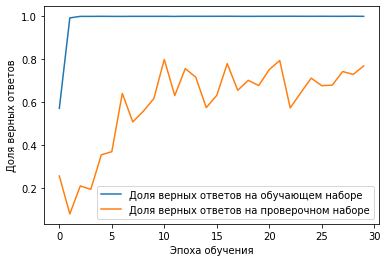

НЕЙРОНКА:  Embedding + Dense

О. Генри  распознано  92 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  74 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  61 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  83 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  90 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  66 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  76 %



In [ ]:
# Embedding + Dense сеть.

# Создаем модель
model1 = Sequential() 

model1.add(Embedding(maxWordsCount, 100, input_length=xLen))
model1.add(SpatialDropout1D(0.4)) 
model1.add(BatchNormalization()) 
model1.add(Conv1D(20, 10, activation="relu")) 
model1.add(Conv1D(20, 10, activation="relu")) 
model1.add(MaxPooling1D(6))
model1.add(Dropout(0.4))
model1.add(BatchNormalization()) 
model1.add(Flatten())
model1.add(Dense(6, activation='softmax')) 

#Компилируем
model1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем
history1 = model1.fit(xTrain, 
                    yTrain, 
                    epochs=30,
                    batch_size=200,
                    validation_data=(xTest, yTest))

#Визуализируем результаты
plt.plot(history1.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history1.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred1 = recognizeMultiClass(model1, xTest6Classes, "Embedding + Dense") #функция покажет какие классы и как распознаны верно

In [ ]:
last_val_accuracy1 = history1.history['val_accuracy'][-1]
print("Нейронка: Embedding + Dense сеть")
print("Точность классификации данных на проверочной выборке:", round(last_val_accuracy1*100, 2), "%")

Нейронка: Embedding + Dense сеть
Точность классификации данных на проверочной выборке: 76.84 %


#### 2. Embedding + LSTM сеть.





Epoch 1/30
89/89 [==============================] - 14s 160ms/step - loss: 1.5751 - accuracy: 0.3865 - val_loss: 1.8409 - val_accuracy: 0.2486
Epoch 2/30
89/89 [==============================] - 13s 152ms/step - loss: 0.9317 - accuracy: 0.6652 - val_loss: 2.0390 - val_accuracy: 0.1497
Epoch 3/30
89/89 [==============================] - 13s 149ms/step - loss: 0.5675 - accuracy: 0.8086 - val_loss: 2.5076 - val_accuracy: 0.2597
Epoch 4/30
89/89 [==============================] - 14s 152ms/step - loss: 0.3919 - accuracy: 0.8773 - val_loss: 2.5355 - val_accuracy: 0.2748
Epoch 5/30
89/89 [==============================] - 14s 153ms/step - loss: 0.2546 - accuracy: 0.9254 - val_loss: 2.1529 - val_accuracy: 0.4696
Epoch 6/30
89/89 [==============================] - 14s 155ms/step - loss: 0.1596 - accuracy: 0.9552 - val_loss: 2.2225 - val_accuracy: 0.5155
Epoch 7/30
89/89 [==============================] - 14s 154ms/step - loss: 0.1246 - accuracy: 0.9660 - val_loss: 1.8490 - val_accuracy: 0.5926

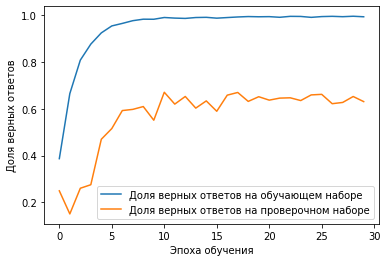

НЕЙРОНКА:  Embedding + LSTM сеть

О. Генри  распознано  66 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  46 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  47 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  37 % сеть считает, что это  Брэдберри ,  распознано НЕ ВЕРНО!
Фрай  распознано  79 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  76 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  63 %

Epoch 1/15
89/89 [==============================] - 14s 158ms/step - loss: 0.0156 - accuracy: 0.9958 - val_loss: 2.0853 - val_accuracy: 0.6420
Epoch 2/15
89/89 [==============================] - 13s 149ms/step - loss: 0.0153 - accuracy: 0.9965 - val_loss: 2.3739 - val_accuracy: 0.6102
Epoch 3/15
89/89 [==============================] - 14s 153ms/step - loss: 0.0162 - accuracy: 0.9963 - val_loss: 1.9570 - val_accuracy: 0.6688
Epoch 4/15
89/89 [=

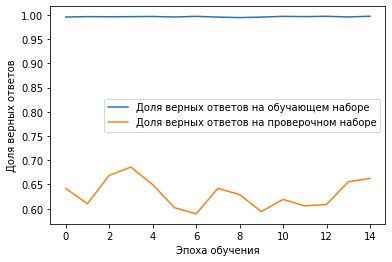

НЕЙРОНКА:  Embedding + LSTM сеть

О. Генри  распознано  62 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  48 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  51 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  71 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  76 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  79 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  66 %



In [ ]:
# Embedding + LSTM сеть

# Создаем модель
model2 = Sequential() 

model2.add(Embedding(maxWordsCount, 100, input_length=xLen))
model2.add(SpatialDropout1D(0.5)) 
model2.add(BatchNormalization()) 
model2.add(LSTM(16, return_sequences=True))
model2.add(LSTM(16))
model2.add(BatchNormalization()) 
model2.add(Dense(6, activation='softmax')) 

#Компилируем
model2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
#Обучаем
history2 = model2.fit(xTrain, 
                    yTrain, 
                    epochs=30,
                    batch_size=200,
                    validation_data=(xTest, yTest))

#Визуализируем результаты
plt.plot(history2.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history2.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred2 = recognizeMultiClass(model2, xTest6Classes, "Embedding + LSTM сеть") #функция покажет какие классы и как распознаны верно

# Дообучим сеть

# Снова компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model2.compile(optimizer='rmsprop', 
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

# Дообучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history2_ = model2.fit(xTrain, 
                    yTrain, 
                    epochs=15,
                    batch_size=200,
                    validation_data=(xTest, yTest))

#Визуализируем результаты
plt.plot(history2_.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history2_.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred2_ = recognizeMultiClass(model2, xTest6Classes, "Embedding + LSTM сеть") #функция покажет какие классы и как распознаны верно

Epoch 1/19
89/89 [==============================] - 14s 152ms/step - loss: 0.0044 - accuracy: 0.9996 - val_loss: 9.3602 - val_accuracy: 0.7255
Epoch 2/19
89/89 [==============================] - 13s 150ms/step - loss: 0.0049 - accuracy: 0.9997 - val_loss: 8.9074 - val_accuracy: 0.7270
Epoch 3/19
89/89 [==============================] - 13s 150ms/step - loss: 0.0027 - accuracy: 0.9998 - val_loss: 7.7459 - val_accuracy: 0.7367
Epoch 4/19
89/89 [==============================] - 13s 150ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 9.0109 - val_accuracy: 0.7430
Epoch 5/19
89/89 [==============================] - 13s 150ms/step - loss: 0.0042 - accuracy: 0.9997 - val_loss: 9.8092 - val_accuracy: 0.7169
Epoch 6/19
89/89 [==============================] - 13s 149ms/step - loss: 2.9747e-04 - accuracy: 0.9999 - val_loss: 6.8249 - val_accuracy: 0.7672
Epoch 7/19
89/89 [==============================] - 13s 150ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 5.7053 - val_accuracy: 0.

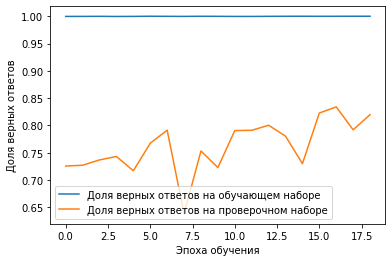

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  92 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  84 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  85 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  62 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  88 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  70 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  81 %



In [ ]:
# Дообучим сеть

# Снова компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model2.compile(optimizer='adam', 
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

# Дообучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history2_ = model2.fit(xTrain, 
                    yTrain, 
                    epochs=19,
                    batch_size=200,
                    validation_data=(xTest, yTest))


# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history2_.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history2_.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred2_ = recognizeMultiClass(model2, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

In [ ]:
last_val_accuracy2 = history2_.history['val_accuracy'][-1]
print("Нейронка: Embedding + LSTM сеть.")
print("Точность классификации данных на проверочной выборке:", round(last_val_accuracy2*100, 2), "%")

Нейронка: Embedding + LSTM сеть.
Точность классификации данных на проверочной выборке: 81.97 %


#### 3. Embedding + Conv1D сеть.

Epoch 1/25
138/138 [==============================] - 3s 22ms/step - loss: 1.2976 - accuracy: 0.5238 - val_loss: 3.1137 - val_accuracy: 0.2928
Epoch 2/25
138/138 [==============================] - 3s 20ms/step - loss: 0.0895 - accuracy: 0.9704 - val_loss: 2.9191 - val_accuracy: 0.2982
Epoch 3/25
138/138 [==============================] - 3s 21ms/step - loss: 0.0194 - accuracy: 0.9930 - val_loss: 1.4154 - val_accuracy: 0.6269
Epoch 4/25
138/138 [==============================] - 3s 20ms/step - loss: 0.0201 - accuracy: 0.9929 - val_loss: 1.4494 - val_accuracy: 0.5975
Epoch 5/25
138/138 [==============================] - 3s 20ms/step - loss: 0.0156 - accuracy: 0.9946 - val_loss: 1.5564 - val_accuracy: 0.6903
Epoch 6/25
138/138 [==============================] - 3s 21ms/step - loss: 0.0167 - accuracy: 0.9945 - val_loss: 0.8165 - val_accuracy: 0.8008
Epoch 7/25
138/138 [==============================] - 3s 20ms/step - loss: 0.0138 - accuracy: 0.9956 - val_loss: 1.8890 - val_accuracy: 0.6317

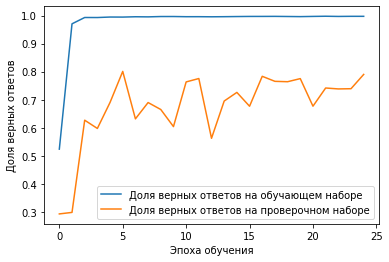

НЕЙРОНКА:  Embedding + Conv1D сеть

О. Генри  распознано  65 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  68 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  82 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  79 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  87 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  76 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  79 %



In [ ]:
# Embedding + Conv1D сеть

# Создаем модель
model3 = Sequential() 

model3.add(Embedding(maxWordsCount, 20, input_length=xLen))
model3.add(SpatialDropout1D(0.4)) 
model3.add(BatchNormalization()) 
model3.add(Conv1D(20, 10, activation="relu"))
model3.add(MaxPooling1D(2)) 
model3.add(Conv1D(20, 10, activation="relu")) 
model3.add(MaxPooling1D(2)) 
model3.add(Dropout(0.4))
model3.add(BatchNormalization())
model3.add(Flatten())
model3.add(Dense(6, activation='softmax')) 

#Компилируем
model3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем
history3 = model3.fit(xTrain, 
                    yTrain, 
                    epochs=25,
                    batch_size=128,
                    validation_data=(xTest, yTest))

#Визуализируем результаты
plt.plot(history3.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history3.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred3 = recognizeMultiClass(model3, xTest6Classes, "Embedding + Conv1D сеть") #функция покажет какие классы и как распознаны верно

In [ ]:
last_val_accuracy3 = history3.history['val_accuracy'][-1]
print("Нейронка: Embedding + Conv1D сеть")
print("Точность классификации данных на проверочной выборке:", round(last_val_accuracy3*100, 2), "%")

Нейронка: Embedding + Conv1D сеть
Точность классификации данных на проверочной выборке: 79.01 %


#### 4. Embedding + сложная сеть из Dense, LSTM и Conv1D.

Epoch 1/25
89/89 [==============================] - 6s 69ms/step - loss: 0.6995 - accuracy: 0.7567 - val_loss: 1.7555 - val_accuracy: 0.3214
Epoch 2/25
89/89 [==============================] - 6s 65ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 1.4530 - val_accuracy: 0.4058
Epoch 3/25
89/89 [==============================] - 6s 65ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.9319 - val_accuracy: 0.6587
Epoch 4/25
89/89 [==============================] - 6s 64ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 1.0497 - val_accuracy: 0.6770
Epoch 5/25
89/89 [==============================] - 6s 65ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 1.7777 - val_accuracy: 0.6891
Epoch 6/25
89/89 [==============================] - 6s 64ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 2.0724 - val_accuracy: 0.7285
Epoch 7/25
89/89 [==============================] - 6s 65ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 1.4947 - val_accuracy: 0.7940
Epoch 8/25
89

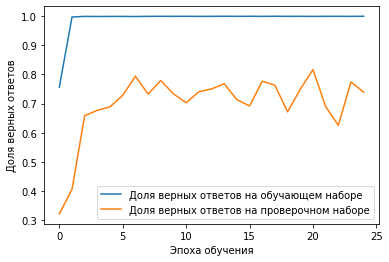

НЕЙРОНКА:  Embedding + сложная сеть из Dense, LSTM и Conv1D

О. Генри  распознано  94 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  92 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  35 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  61 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  84 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  77 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  73 %



In [ ]:
# Embedding + сложная сеть из Dense, LSTM и Conv1D

# Создаем модель
model4 = Sequential() 

model4.add(Embedding(maxWordsCount, 50, input_length=xLen))
model4.add(SpatialDropout1D(0.2)) 
model4.add(Conv1D(20, 10, activation="relu"))
model4.add(MaxPooling1D(2))
model4.add(Dropout(0.5)) 
model4.add(BatchNormalization()) 
model4.add(LSTM(16, return_sequences=1)) 
model4.add(Dropout(0.5))
model4.add(BatchNormalization()) 
model4.add(Flatten()) 
model4.add(Dense(6, activation='softmax'))

#Компилируем
model4.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем
history4 = model4.fit(xTrain, 
                    yTrain, 
                    epochs=25,
                    batch_size=200,
                    validation_data=(xTest, yTest))

#Визуализируем результаты
plt.plot(history4.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history4.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred4 = recognizeMultiClass(model4, xTest6Classes, "Embedding + сложная сеть из Dense, LSTM и Conv1D") #функция покажет какие классы и как распознаны верно

Epoch 1/15
89/89 [==============================] - 6s 71ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 4.2524 - val_accuracy: 0.7158
Epoch 2/15
89/89 [==============================] - 6s 66ms/step - loss: 0.0049 - accuracy: 0.9993 - val_loss: 2.9433 - val_accuracy: 0.7890
Epoch 3/15
89/89 [==============================] - 6s 66ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 3.2257 - val_accuracy: 0.7838
Epoch 4/15
89/89 [==============================] - 6s 66ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 3.9695 - val_accuracy: 0.7600
Epoch 5/15
89/89 [==============================] - 6s 66ms/step - loss: 0.0015 - accuracy: 0.9994 - val_loss: 2.7526 - val_accuracy: 0.8116
Epoch 6/15
89/89 [==============================] - 6s 67ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 3.8807 - val_accuracy: 0.7535
Epoch 7/15
89/89 [==============================] - 6s 67ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 3.3540 - val_accuracy: 0.7983
Epoch 8/15
89

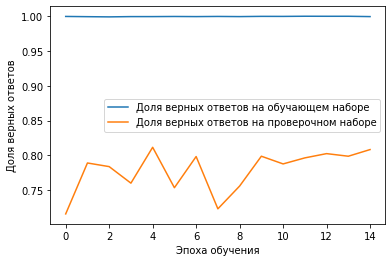

НЕЙРОНКА:  Embedding + сложная сеть из Dense, LSTM и Conv1D

О. Генри  распознано  86 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  39 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  83 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  72 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  93 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  94 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  80 %



In [ ]:
# Дообучим сеть

# Снова компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model4.compile(optimizer='adam', 
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

# Дообучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history4_ = model4.fit(xTrain, 
                    yTrain, 
                    epochs=15,
                    batch_size=200,
                    validation_data=(xTest, yTest))


# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history4_.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history4_.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred4_ = recognizeMultiClass(model4, xTest6Classes, "Embedding + сложная сеть из Dense, LSTM и Conv1D") #функция покажет какие классы и как распознаны верно

In [ ]:
last_val_accuracy4 = history4_.history['val_accuracy'][-1]
print("Нейронка: Embedding + сложная сеть из Dense, LSTM и Conv1D")
print("Точность классификации данных на проверочной выборке:", round(last_val_accuracy4*100, 2), "%")

Нейронка: Embedding + сложная сеть из Dense, LSTM и Conv1D
Точность классификации данных на проверочной выборке: 80.83 %


#### **Итоги:**

Нейронка: **Embedding + Dense** дала точность классификации данных на проверочной выборке: **76.84%**

Нейронка: **Embedding + LSTM** дала точность классификации данных на проверочной выборке: **81.97%**

Нейронка: **Embedding + Conv1D** дала точность классификации данных на проверочной выборке: **79.01%**

Нейронка: **Embedding + сложная сеть из Dense, LSTM и Conv1D** дала точность классификации данных на проверочной выборке: **80.83%**

Данные результаты не очень высокие, но и не плохие. При дальнейшей проработке архитектур процент распознавания можно увеличить. Так как целью данного блока было потренироваться писать рекурентные и сверточные цели, а не доводить их до идеала - результат можно считать отличным!

**P.S.** Я перебрала такое каличество архитектур, и прогнала столько сеток, что colab ограничел мне доступ к GPU за столь активную работу... так что вот чего чего а в написании сеток я натренировалась отдуши:)) 




## **PRO**

### **Вариант 1:**

Напишите классификацию заболеваний по базе симптомов, используя любые подходы, связанные с обработкой текстов.
1. Embedding + LSTM сеть.
2. Embedding + Conv1D сеть.
3. Embedding + сложная сеть из Dense, LSTM и Conv1D.


Добейтесь максимальной точности распознавания.
Используйте xLen = 50.


In [ ]:
import os # Для работы с файлами
from google.colab import files #модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных
import pandas as pd #библиотека для обработки и анализа данных
import matplotlib.pyplot as plt #библиотека для визуализации данных
# "Магическая"команда python для запуска библиотеки в ноутбуке
%matplotlib inline

from tensorflow.keras import utils #модуль с утилитами кераса, будем использовать для вызова метода преобразования категорий в вектора
from tensorflow.keras.models import Sequential #последовательная модель нейросети кераса
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
# Загружаем алгоритмы обучения/оптимизации
from tensorflow.python.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence #инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split #модуль для разбиения данных на обучающую и тестовую выборки

**Парсинг базы**

База симптомов, предварительно была разделена на обучающий и тестовый набор симптомов. Был взят послный список симптомов заболевания (предоставленная Университетом база) и разделен на два списка - обучающий и тестовый, в пропорции 20 к 80. Тоесть тестовый набор симптомов составил 20% от изнаального текста, а обучающий - 80%. Так как по условию задачи "используя любые подходы, связанные с обработкой текстов" - то я предпочла такой способ обработки, как самый понятный для меня и который получил неплохой результат - показав что выбранный подход был выбран правильно. 

In [ ]:
!rm -R /content/texts 
!unzip -q '/content/drive/My Drive/Colab Notebooks/Базы/База симптомов.zip' -d /content/texts 

rm: cannot remove '/content/texts': No such file or directory


In [ ]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        
  text = f.read()                
  text = text.replace("\n", " ") 
  
  return text                    

# Объявляем интересующие нас классы
className = ["Аппендицит", "Гастрит", "Гепатит", "Дуоденит", "Колит", "Панкреатит", "Холицестит", "Эзофагит", "Энтерит", "Язва"] 
nClasses = len(className) 


#Загружаем обучающие тексты

trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

for i in className: 
  for j in os.listdir('texts/База симптомов/'): 
    if i in j: 
      if 'Обучающая' in j:
        trainText.append(readText('texts/База симптомов/' + j))
        print(j, 'добавлен в обучающую выборку') 
      if 'Тестовая' in j:
        testText.append(readText('texts/База симптомов/' + j))
        print(j, 'добавлен в тестовую выборку')
  print()


(Аппендицит) Обучающая.txt добавлен в обучающую выборку
(Аппендицит) Тестовая.txt добавлен в тестовую выборку

(Гастрит) Тестовая.txt добавлен в тестовую выборку
(Гастрит) Обучающая.txt добавлен в обучающую выборку

(Гепатит) Тестовая.txt добавлен в тестовую выборку
(Гепатит) Обучающая.txt добавлен в обучающую выборку

(Дуоденит) Тестовая.txt добавлен в тестовую выборку
(Дуоденит) Обучающая.txt добавлен в обучающую выборку

(Колит) Обучающая.txt добавлен в обучающую выборку
(Колит) Тестовая.txt добавлен в тестовую выборку

(Панкреатит) Тестовая.txt добавлен в тестовую выборку
(Панкреатит) Обучающая.txt добавлен в обучающую выборку

(Холицестит) Обучающая.txt добавлен в обучающую выборку
(Холицестит) Тестовая.txt добавлен в тестовую выборку

(Эзофагит) Обучающая.txt добавлен в обучающую выборку
(Эзофагит) Тестовая.txt добавлен в тестовую выборку

(Энтерит) Обучающая.txt добавлен в обучающую выборку
(Энтерит) Тестовая.txt добавлен в тестовую выборку

(Язва) Обучающая.txt добавлен в обуча

In [ ]:
# Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью

maxWordsCount = 20000 # определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

# для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower=True, split=' ', char_level=False, oov_token = 'unknown')

tokenizer.fit_on_texts(trainText) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра

In [ ]:
print(items[:100]) # взглянем на содержимое словаря

[('unknown', 1), ('в', 2), ('и', 3), ('боль', 4), ('тошнота', 5), ('или', 6), ('боли', 7), ('рвота', 8), ('живота', 9), ('при', 10), ('после', 11), ('животе', 12), ('области', 13), ('отрыжка', 14), ('с', 15), ('слабость', 16), ('аппетита', 17), ('во', 18), ('тела', 19), ('может', 20), ('изжога', 21), ('вздутие', 22), ('до', 23), ('снижение', 24), ('диарея', 25), ('еды', 26), ('пищи', 27), ('к', 28), ('на', 29), ('иногда', 30), ('рту', 31), ('повышение', 32), ('температуры', 33), ('температура', 34), ('не', 35), ('подреберье', 36), ('метеоризм', 37), ('потеря', 38), ('стул', 39), ('правом', 40), ('желудка', 41), ('части', 42), ('верхней', 43), ('общая', 44), ('чувство', 45), ('урчание', 46), ('эпигастральной', 47), ('время', 48), ('ощущение', 49), ('тяжести', 50), ('которая', 51), ('могут', 52), ('запор', 53), ('ощущения', 54), ('отсутствие', 55), ('нарушение', 56), ('стула', 57), ('позывы', 58), ('приема', 59), ('повышенная', 60), ('кожи', 61), ('эпигастрии', 62), ('понос', 63), ('особ

In [ ]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)   # проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1] [:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20])

print()
print()

print("Статистика по обучающим текстам:")
for i in range(6):
  print(className[i], " ", len(trainText[i]), " символов, ", len(trainWordIndexes[i]), " слов")
print("В сумме ", len(trainText[0])+len(trainText[1])+len(trainText[2])+len(trainText[3])+len(trainText[4])+len(trainText[5]), " символов, ", len(trainWordIndexes[0])+len(trainWordIndexes[1])+len(trainWordIndexes[2])+len(trainWordIndexes[3])+len(trainWordIndexes[4])+len(trainWordIndexes[5]), " слов")
print()
print("Статистика по обучающим текстам:")
for i in range(6):
  print(className[i], " ", len(testText[i]), " символов, ", len(testWordIndexes[i]), " слов")
print("В сумме ", len(testText[0])+len(testText[1])+len(testText[2])+len(testText[3])+len(testText[4])+len(testText[5]), " символов, ", len(testWordIndexes[0])+len(testWordIndexes[1])+len(testWordIndexes[2])+len(testWordIndexes[3])+len(testWordIndexes[4])+len(testWordIndexes[5]), " слов")

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Дискомфорте, сдавленности (особенно — после еды) в области эпигастрия (верхн его отдела
Он же в виде последовательности индексов:  [762, 763, 64, 11, 26, 2, 13, 335, 764, 255, 765, 496, 7, 2, 766, 256, 13, 767, 768, 769]


Статистика по обучающим текстам:
Аппендицит   3162  символов,  450  слов
Гастрит   4296  символов,  554  слов
Гепатит   4530  символов,  560  слов
Дуоденит   3276  символов,  413  слов
Колит   7527  символов,  987  слов
Панкреатит   8444  символов,  1107  слов
В сумме  31235  символов,  4071  слов

Статистика по обучающим текстам:
Аппендицит   911  символов,  129  слов
Гастрит   2411  символов,  284  слов
Гепатит   991  символов,  127  слов
Дуоденит   662  символов,  75  слов
Колит   1598  символов,  205  слов
Панкреатит   2863  символов,  373  слов
В сумме  9436  символов,  1193  слов


In [ ]:
# Формирование обучающей выборки по листу индексов слов

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  
  # Идём по всей длине вектора индексов
  # "Откусываем" векторы длины xLen и смещаеммся вперёд на step
  
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample

In [ ]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов

def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  nClasses = len(wordIndexes) 
  classesXSamples = []        
  for wI in wordIndexes:      
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] 
  ySamples = [] 
  
  for t in range(nClasses):  # в диапазоне кол-ва классов
    xT = classesXSamples[t]  
    for i in range(len(xT)): # и каждое его окно
      xSamples.append(xT[i]) 
    
    # Формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) 
    for i in range(len(xT)): # на каждое окно выборки 
      ySamples.append(currY) 

  # переводим в массив numpy для подачи в нейронку
  xSamples = np.array(xSamples) 
  ySamples = np.array(ySamples) 
  
  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

In [ ]:
# Задаём базовые параметры
# По условию задачи xLen = 50

xLen = 50 # Длина отрезка текста, по которой анализируем, в словах
step = 1 # Шаг разбиения исходного текста на обучающие вектора

In [ ]:
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
# получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1

(5884, 50)
(5884, 10)
(1334, 50)
(1334, 10)


In [ ]:
# Представляем тестовую выборку в удобных для распознавания размерах

def createTestMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  nClasses = len(wordIndexes) 
  xTest6Classes01 = []               
  xTest6Classes = []                 
  for wI in wordIndexes:             
    sample = (getSetFromIndexes(wI, xLen, step)) 
    xTest6Classes.append(np.array(sample))       
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) 
  xTest6Classes01 = np.array(xTest6Classes01)                    
  
  return xTest6Classes01, xTest6Classes # функция вернёт тестовые данные


# Расспознаём тестовую выборку и выводим результаты

def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  val = []
  pred = []
  
  totalSumRec = []
  
  # Проходим по всем классам
  for i in range(nClasses):
    # Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    # Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)
    
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))
    
    totalSumRec.append(sumRec[i])
    
    # Определяем, какой в класс в итоге за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)
    
    # Выводим результаты распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)
  
  # Выводим вредний процент распознавания по всем классам вместе
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
  print()
  return sumVal/sumCount

xTest6Classes01, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) # подгоним форму тестовых классов под функцию recognizeMultiClass

#### 1. Embedding + LSTM сеть

Epoch 1/80
31/31 [==============================] - 2s 62ms/step - loss: 1.7715 - accuracy: 0.4117 - val_loss: 2.2401 - val_accuracy: 0.2968
Epoch 2/80
31/31 [==============================] - 1s 32ms/step - loss: 0.7197 - accuracy: 0.8240 - val_loss: 2.1147 - val_accuracy: 0.4251
Epoch 3/80
31/31 [==============================] - 1s 33ms/step - loss: 0.2715 - accuracy: 0.9644 - val_loss: 1.9127 - val_accuracy: 0.3519
Epoch 4/80
31/31 [==============================] - 1s 33ms/step - loss: 0.0918 - accuracy: 0.9956 - val_loss: 1.7750 - val_accuracy: 0.3714
Epoch 5/80
31/31 [==============================] - 1s 34ms/step - loss: 0.0352 - accuracy: 0.9990 - val_loss: 1.8632 - val_accuracy: 0.3721
Epoch 6/80
31/31 [==============================] - 1s 34ms/step - loss: 0.0175 - accuracy: 0.9992 - val_loss: 1.8041 - val_accuracy: 0.4265
Epoch 7/80
31/31 [==============================] - 1s 33ms/step - loss: 0.0112 - accuracy: 0.9989 - val_loss: 1.8713 - val_accuracy: 0.4621
Epoch 8/80
31

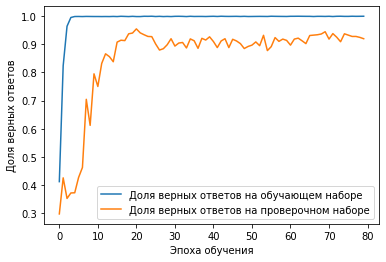

НЕЙРОНКА:  Embedding + LSTM сеть

Аппендицит  распознано  100 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  83 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Гепатит  распознано  100 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  100 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  98 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  93 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  94 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  100 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  100 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  64 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  92 %

Epoch 1/40
21/21 [==============================] - 2s 86ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.3776 - val_accurac

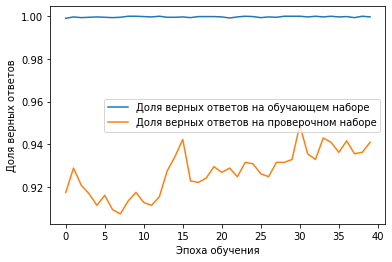

НЕЙРОНКА:  Embedding + LSTM сеть

Аппендицит  распознано  100 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  94 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Гепатит  распознано  100 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  100 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  98 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  92 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  98 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  100 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  100 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  63 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  94 %



In [ ]:
# Embedding + LSTM сеть

# Создаем модель
model1 = Sequential() 

model1.add(Embedding(maxWordsCount, 40, input_length=xLen))
model1.add(SpatialDropout1D(0.5)) 
model1.add(BatchNormalization()) 
model1.add(Bidirectional(LSTM(16))) # двунаправленный
model1.add(BatchNormalization()) 
model1.add(Dense(10, activation='softmax')) 

#Компилируем
model1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
#Обучаем
history1 = model1.fit(xTrain, 
                    yTrain, 
                    epochs=80,
                    batch_size=200,
                    validation_data=(xTest, yTest))

#Визуализируем результаты
plt.plot(history1.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history1.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred1 = recognizeMultiClass(model1, xTest6Classes, "Embedding + LSTM сеть") #функция покажет какие классы и как распознаны верно


# Дообучим сеть

# Снова компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model1.compile(optimizer='rmsprop', 
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

# Дообучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history1_ = model1.fit(xTrain, 
                    yTrain, 
                    epochs=40,
                    batch_size=300,
                    validation_data=(xTest, yTest))

#Визуализируем результаты
plt.plot(history1_.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history1_.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred1_ = recognizeMultiClass(model1, xTest6Classes, "Embedding + LSTM сеть") #функция покажет какие классы и как распознаны верно

In [ ]:
history1_.history['val_accuracy'][-1]
print("Нейронка: Embedding + LSTM сеть")
print("Точность классификации данных на проверочной выборке:", round(last_val_accuracy1*100, 2), "%")

Нейронка: Embedding + LSTM сеть
Точность классификации данных на проверочной выборке: 94.09 %


#### 2. Embedding + Conv1D сеть

Epoch 1/30
25/25 [==============================] - 3s 106ms/step - loss: 2.7567 - accuracy: 0.1487 - val_loss: 2.3041 - val_accuracy: 0.1527
Epoch 2/30
25/25 [==============================] - 2s 100ms/step - loss: 1.5789 - accuracy: 0.4584 - val_loss: 2.3371 - val_accuracy: 0.1710
Epoch 3/30
25/25 [==============================] - 2s 98ms/step - loss: 0.6854 - accuracy: 0.7835 - val_loss: 2.3715 - val_accuracy: 0.1201
Epoch 4/30
25/25 [==============================] - 2s 99ms/step - loss: 0.2990 - accuracy: 0.9294 - val_loss: 2.4376 - val_accuracy: 0.1371
Epoch 5/30
25/25 [==============================] - 2s 98ms/step - loss: 0.1571 - accuracy: 0.9681 - val_loss: 2.4945 - val_accuracy: 0.1266
Epoch 6/30
25/25 [==============================] - 2s 99ms/step - loss: 0.1038 - accuracy: 0.9811 - val_loss: 2.4307 - val_accuracy: 0.1449
Epoch 7/30
25/25 [==============================] - 2s 99ms/step - loss: 0.0734 - accuracy: 0.9880 - val_loss: 2.3986 - val_accuracy: 0.1456
Epoch 8/30


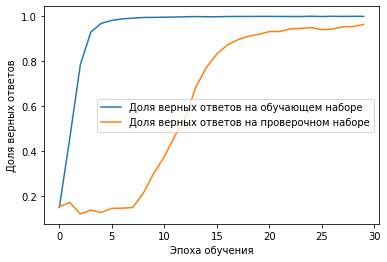

НЕЙРОНКА:  Embedding + Conv1D сеть

Аппендицит  распознано  95 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  86 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Гепатит  распознано  100 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  100 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  100 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  100 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  100 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  100 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  100 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  85 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  96 %



In [ ]:
# Embedding + Conv1D сеть

# Создаем модель
model2 = Sequential() 

model2.add(Embedding(maxWordsCount, 30, input_length=xLen))
model2.add(SpatialDropout1D(0.5))
model2.add(BatchNormalization()) 
model2.add(Conv1D(50, 10, activation="relu"))
model2.add(Conv1D(50, 10, activation="relu")) 
model2.add(MaxPooling1D(4)) 
model2.add(Dropout(0.5)) 
model2.add(BatchNormalization()) 
model2.add(Flatten()) 
model2.add(Dense(10, activation='softmax')) 


#Компилируем
model2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем
history2 = model2.fit(xTrain, 
                    yTrain, 
                    epochs=30,
                    batch_size=250,
                    validation_data=(xTest, yTest))

#Визуализируем результаты
plt.plot(history2.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history2.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred2 = recognizeMultiClass(model2, xTest6Classes, "Embedding + Conv1D сеть") #функция покажет какие классы и как распознаны верно



In [ ]:
last_val_accuracy2 = history2.history['val_accuracy'][-1]
print("Нейронка: Embedding + Conv1D сеть")
print("Точность классификации данных на проверочной выборке:", round(last_val_accuracy2*100, 2), "%")

Нейронка: Embedding + Conv1D сеть
Точность классификации данных на проверочной выборке: 96.34 %


#### 3. Embedding + сложная сеть из Dense, LSTM и Conv1D

Epoch 1/30
32/32 [==============================] - 11s 359ms/step - loss: 1.3255 - accuracy: 0.5620 - val_loss: 2.2651 - val_accuracy: 0.0633
Epoch 2/30
32/32 [==============================] - 10s 303ms/step - loss: 0.2251 - accuracy: 0.9316 - val_loss: 2.3731 - val_accuracy: 0.0633
Epoch 3/30
32/32 [==============================] - 9s 293ms/step - loss: 0.0844 - accuracy: 0.9760 - val_loss: 2.6651 - val_accuracy: 0.0666
Epoch 4/30
32/32 [==============================] - 9s 296ms/step - loss: 0.0583 - accuracy: 0.9825 - val_loss: 2.8866 - val_accuracy: 0.1142
Epoch 5/30
32/32 [==============================] - 10s 304ms/step - loss: 0.0393 - accuracy: 0.9882 - val_loss: 2.8536 - val_accuracy: 0.1495
Epoch 6/30
32/32 [==============================] - 10s 303ms/step - loss: 0.0235 - accuracy: 0.9915 - val_loss: 2.1502 - val_accuracy: 0.2670
Epoch 7/30
32/32 [==============================] - 9s 297ms/step - loss: 0.0247 - accuracy: 0.9930 - val_loss: 2.5174 - val_accuracy: 0.2278
Ep

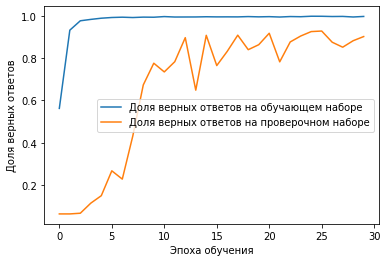

НЕЙРОНКА:  Embedding + сложная сеть из Dense, LSTM и Conv1D

Аппендицит  распознано  100 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  85 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Гепатит  распознано  100 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  74 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  100 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  91 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  89 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  92 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  100 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  66 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  90 %



In [ ]:
# Embedding + сложная сеть из Dense, LSTM и Conv1D

# Создаем модель
model3 = Sequential() 

model3.add(Embedding(maxWordsCount, 30, input_length=xLen))
model3.add(SpatialDropout1D(0.5)) 
model3.add(Bidirectional(LSTM(16, return_sequences=True)))
model3.add(Dense(100, activation='relu')) 
model3.add(Conv1D(100, 10, activation="relu")) 
model3.add(LSTM(16, return_sequences=True))
model3.add(Dropout(0.5)) 
model3.add(BatchNormalization()) 
model3.add(Conv1D(100, 10, activation="relu")) 
model3.add(MaxPooling1D(3)) 
model3.add(Dropout(0.5)) 
model3.add(BatchNormalization()) 
model3.add(Flatten()) 
model3.add(Dense(10, activation='softmax'))

#Компилируем
model3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем
history3 = model3.fit(xTrain, 
                    yTrain, 
                    epochs=30,
                    batch_size=200,
                    validation_data=(xTest, yTest))

#Визуализируем результаты
plt.plot(history3.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history3.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred3 = recognizeMultiClass(model3, xTest6Classes, "Embedding + сложная сеть из Dense, LSTM и Conv1D") #функция покажет какие классы и как распознаны верно



In [ ]:
last_val_accuracy3 = history3.history['val_accuracy'][-1]
print("Нейронка: Embedding + сложная сеть из Dense, LSTM и Conv1D")
print("Точность классификации данных на проверочной выборке:", round(last_val_accuracy3*100, 2), "%")


Нейронка: Embedding + сложная сеть из Dense, LSTM и Conv1D
Точность классификации данных на проверочной выборке: 90.14 %


#### **Итог:**


Нейронка: **Embedding + LSTM** дала точность классификации данных на проверочной выборке: **94.09%**

Нейронка: **Embedding + Conv1D** дала точность классификации данных на проверочной выборке: **96.34%**

Нейронка: **Embedding + сложная сеть из Dense, LSTM и Conv1D** дала точность классификации данных на проверочной выборке: **90.14%**

Все полученные результаты можно считать очень хорошими, а данные архитектурные подходы хорошо подходящими для решения подобных задач.

## **ULTRA PRO**




### **Задание:** 
Найдите любую базу с текстами разных классов и напишите их распознавание, используя рекуррентные или сверточные слои. Для этого выполните следующее:
* Спарсите тексты, превратите их в индексы.
* Разделите данные на обучающую и проверочную выборки.
* Напишите сеть для распознавания текстов.
* Сделайте визуализацию результата.
* Напишите ваши результаты и выводы.

In [ ]:
from google.colab import files #модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных
import pandas as pd #библиотека для обработки и анализа данных
import matplotlib.pyplot as plt #библиотека для визуализации данных
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils #модуль с утилитами кераса, будем использовать для вызова метода преобразования категорий в вектора
from tensorflow.keras.models import Sequential #последовательная модель нейросети кераса
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import SpatialDropout1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM
# Загружаем алгоритмы обучения/оптимизации
from tensorflow.python.keras.optimizers import Adam

from keras.preprocessing.text import Tokenizer, text_to_word_sequence #инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split #модуль для разбиения данных на обучающую и тестовую выборки

**База:** Для выполнения данного задания была собственноручно собрана база "Русские исполнители", которая состоит из текстов песен шести российских исполнителей. 3 - женский вокал, 3 - мужской. Задача: классификация исполнителя по тексту песни. 

Для решения данной задачи была выбрана рекуррентная сеть Embedding + LSTM.

In [ ]:
# Указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/drive/My Drive/Colab Notebooks/Базы/Русские исполнители.zip' -d /content/texts 

In [ ]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  
  return text                    # Возвращаем текст файла

className = ["Ваенга", "Егор Крид", "Кино", "Кипелов", "Надежда Кадышева", "Тату"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

In [ ]:
#Загружаем обучающие тексты

trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

for i in className: 
  for j in os.listdir('texts/Русские исполнители/'): 
    if i in j: 
      if 'Обучающая' in j: 
        trainText.append(readText('texts/Русские исполнители/' + j)) 
        print(j, 'добавлен в обучающую выборку') 
      if 'Тестовая' in j:
        testText.append(readText('texts/Русские исполнители/' + j)) 
        print(j, 'добавлен в тестовую выборку') 
  print()

(Ваенга) Тестовая.txt добавлен в тестовую выборку
(Ваенга) Обучающая.txt добавлен в обучающую выборку

(Егор Крид) Тестовая.txt добавлен в тестовую выборку
(Егор Крид) Обучающая.txt добавлен в обучающую выборку

(Кино) Обучающая.txt добавлен в обучающую выборку
(Кино) Тестовая.txt добавлен в тестовую выборку

(Кипелов) Тестовая.txt добавлен в тестовую выборку
(Кипелов) Обучающая.txt добавлен в обучающую выборку

(Надежда Кадышева) Тестовая.txt добавлен в тестовую выборку
(Надежда Кадышева) Обучающая.txt добавлен в обучающую выборку

(Тату) Обучающая.txt добавлен в обучающую выборку
(Тату) Тестовая.txt добавлен в тестовую выборку



In [ ]:
# Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью

maxWordsCount = 20000 # определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

# для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower=True, split=' ', char_level=False, oov_token = 'unknown')

tokenizer.fit_on_texts(trainText) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра

In [ ]:
print(items[:100]) # взглянем на содержимое словаря

[('unknown', 1), ('я', 2), ('не', 3), ('и', 4), ('в', 5), ('ты', 6), ('на', 7), ('мне', 8), ('с', 9), ('а', 10), ('что', 11), ('тебя', 12), ('меня', 13), ('но', 14), ('мама', 15), ('все', 16), ('как', 17), ('мы', 18), ('она', 19), ('покажи', 20), ('так', 21), ('любовь', 22), ('только', 23), ('кто', 24), ('м', 25), ('за', 26), ('тобой', 27), ('без', 28), ('это', 29), ('то', 30), ('снова', 31), ('у', 32), ('где', 33), ('до', 34), ('ночь', 35), ('ее', 36), ('по', 37), ('ума', 38), ('нас', 39), ('робот', 40), ('припев', 41), ('нужна', 42), ('тебе', 43), ('потрачу', 44), ('же', 45), ('полчаса', 46), ('раз', 47), ('люблю', 48), ('был', 49), ('о', 50), ('день', 51), ('от', 52), ('нет', 53), ('хочу', 54), ('уходи', 55), ('досчитай', 56), ('да', 57), ('па', 58), ('сердце', 59), ('больше', 60), ('нравится', 61), ('еще', 62), ('сошла', 63), ('знаю', 64), ('если', 65), ('он', 66), ('свободен', 67), ('полетели', 68), ('бы', 69), ('ли', 70), ('небо', 71), ('когда', 72), ('чем', 73), ('к', 74), ('из'

In [ ]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)   # проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1] [:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20])

print()
print()

print("Статистика по обучающим текстам:")
for i in range(6):
  print(className[i], " ", len(trainText[i]), " символов, ", len(trainWordIndexes[i]), " слов")
print("В сумме ", len(trainText[0])+len(trainText[1])+len(trainText[2])+len(trainText[3])+len(trainText[4])+len(trainText[5]), " символов, ", len(trainWordIndexes[0])+len(trainWordIndexes[1])+len(trainWordIndexes[2])+len(trainWordIndexes[3])+len(trainWordIndexes[4])+len(trainWordIndexes[5]), " слов")
print()
print("Статистика по обучающим текстам:")
for i in range(6):
  print(className[i], " ", len(testText[i]), " символов, ", len(testWordIndexes[i]), " слов")
print("В сумме ", len(testText[0])+len(testText[1])+len(testText[2])+len(testText[3])+len(testText[4])+len(testText[5]), " символов, ", len(testWordIndexes[0])+len(testWordIndexes[1])+len(testWordIndexes[2])+len(testWordIndexes[3])+len(testWordIndexes[4])+len(testWordIndexes[5]), " слов")

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Потрачу  Я бы улетел с тобою, не брав парашюты. Убрал все стрелки на часах, не считая м
Он же в виде последовательности индексов:  [44, 2, 69, 1218, 9, 753, 3, 1219, 1220, 1221, 16, 525, 7, 1222, 3, 550, 1223, 5, 265, 1224]


Статистика по обучающим текстам:
Ваенга   9111  символов,  1745  слов
Егор Крид   14032  символов,  2492  слов
Кино   7211  символов,  1249  слов
Кипелов   9453  символов,  1608  слов
Надежда Кадышева   8154  символов,  1382  слов
Тату   9206  символов,  1600  слов
В сумме  57167  символов,  10076  слов

Статистика по обучающим текстам:
Ваенга   2667  символов,  485  слов
Егор Крид   2802  символов,  485  слов
Кино   1685  символов,  287  слов
Кипелов   2377  символов,  380  слов
Надежда Кадышева   1843  символов,  299  слов
Тату   1659  символов,  331  слов
В сумме  13033  символов,  2267  слов


In [ ]:
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  
  # Идём по всей длине вектора индексов
  # "Откусываем" векторы длины xLen и смещаеммся вперёд на step
  
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample

In [ ]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов

def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) 
  classesXSamples = []        
  for wI in wordIndexes:      
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) 

  # Формируем один общий xSamples
  xSamples = [] 
  ySamples = [] 
  
  for t in range(nClasses):  
    xT = classesXSamples[t] 
    for i in range(len(xT)):
      xSamples.append(xT[i]) 
    
    # Формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) 
    for i in range(len(xT)): 
      ySamples.append(currY) 

  xSamples = np.array(xSamples) 
  ySamples = np.array(ySamples) 

  
  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

In [ ]:
# Задаём базовые параметры
xLen = 5 # Длина отрезка текста, по которой анализируем, в словах
step = 1 # Шаг разбиения исходного текста на обучающие вектора

In [ ]:
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(10052, 5)
(10052, 6)
(2243, 5)
(2243, 6)


In [ ]:
# Представляем тестовую выборку в удобных для распознавания размерах

def createTestMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes)
  xTest6Classes01 = []              
  xTest6Classes = []                 
  for wI in wordIndexes:             
    sample = (getSetFromIndexes(wI, xLen, step)) 
    xTest6Classes.append(np.array(sample))       
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) 
  xTest6Classes01 = np.array(xTest6Classes01)                     
  
  return xTest6Classes01, xTest6Classes # функция вернёт тестовые данные

# Расспознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  val = []
  pred = []
  
  totalSumRec = []
  
  # Проходим по всем классам
  for i in range(nClasses):
    # Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    # Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)
    
    # Считаем процент распознавания каждого класса за каждый
    # Получам матрицу 6 на 6
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))
    
    totalSumRec.append(sumRec[i])
    
    # Определяем, какой в класс в итоге за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)
    
    # Выводим результаты распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)
  
  # Выводим вредний процент распознавания по всем классам вместе
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
  print()
  return sumVal/sumCount

xTest6Classes01, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) # подгоним форму тестовых классов под функцию recognizeMultiClass

Epoch 1/30
20/20 [==============================] - 1s 36ms/step - loss: 1.7202 - accuracy: 0.3212 - val_loss: 1.7783 - val_accuracy: 0.2162
Epoch 2/30
20/20 [==============================] - 0s 11ms/step - loss: 1.6200 - accuracy: 0.4791 - val_loss: 1.7656 - val_accuracy: 0.2207
Epoch 3/30
20/20 [==============================] - 0s 10ms/step - loss: 1.5442 - accuracy: 0.5542 - val_loss: 1.7506 - val_accuracy: 0.2470
Epoch 4/30
20/20 [==============================] - 0s 11ms/step - loss: 1.4751 - accuracy: 0.6195 - val_loss: 1.7328 - val_accuracy: 0.2876
Epoch 5/30
20/20 [==============================] - 0s 10ms/step - loss: 1.4156 - accuracy: 0.6523 - val_loss: 1.7109 - val_accuracy: 0.3370
Epoch 6/30
20/20 [==============================] - 0s 10ms/step - loss: 1.3606 - accuracy: 0.6721 - val_loss: 1.6832 - val_accuracy: 0.3995
Epoch 7/30
20/20 [==============================] - 0s 11ms/step - loss: 1.3105 - accuracy: 0.6909 - val_loss: 1.6503 - val_accuracy: 0.4338
Epoch 8/30
20

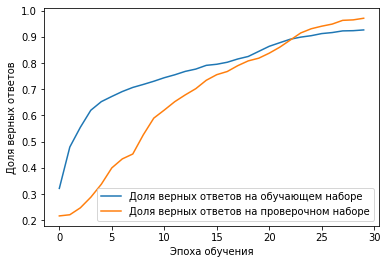

НЕЙРОНКА:  Embedding + LSTM

Ваенга  распознано  99 % сеть считает, что это  Ваенга ,  распознано ВЕРНО!
Егор Крид  распознано  99 % сеть считает, что это  Егор Крид ,  распознано ВЕРНО!
Кино  распознано  84 % сеть считает, что это  Кино ,  распознано ВЕРНО!
Кипелов  распознано  98 % сеть считает, что это  Кипелов ,  распознано ВЕРНО!
Надежда Кадышева  распознано  97 % сеть считает, что это  Надежда Кадышева ,  распознано ВЕРНО!
Тату  распознано  98 % сеть считает, что это  Тату ,  распознано ВЕРНО!

Средний процент распознавания  97 %



In [ ]:
# Создадим рекурентную нейронную сеть и обучим её

modelEL = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization()) # добавляем слой нормализации данных
modelEL.add(LSTM(4))
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEL.fit(xTrain, 
                    yTrain, 
                    epochs=30,
                    batch_size=512,
                    validation_data=(xTest, yTest))

# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

pred = recognizeMultiClass(modelEL, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

In [ ]:
# Смотрин на точность классификации данных на проверочной выборке на последней эпохе обучения
last_val_accuracy = history.history['val_accuracy'][-1]
print("Точность классификации данных на проверочной выборке:", round(last_val_accuracy*100, 2), "%")

Точность классификации данных на проверочной выборке: 97.06 %


### **Результаты и выводы:**

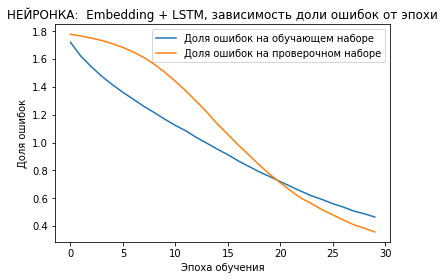

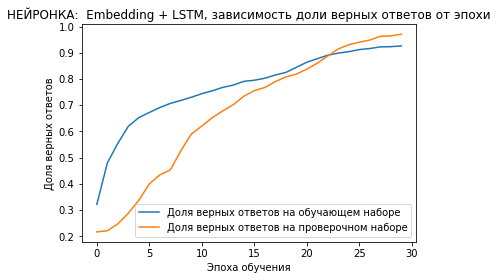

In [ ]:
# Визуализируем данные, для подведения итога:

plt.plot(history.history['loss'], 
         label='Доля ошибок на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Доля ошибок на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля ошибок')
plt.title("НЕЙРОНКА:  Embedding + LSTM, зависимость доли ошибок от эпохи")
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title("НЕЙРОНКА:  Embedding + LSTM, зависимость доли верных ответов от эпохи")
plt.legend()
plt.show()



Средний процент распознавания музыканта, по тексту его песен составил **97 %**

Точность классификации на проверочной выборке составила  **97.06 %** (на последней эпохе)

Данные показатели говорят о хорошей работе созданной рекуррентной сети. На выходе мы видим высокий процент распознавания и отсутствие переобучения.

Подводя итог, можно сказать что рекуррентная нейронная сеть Embedding + LSTM хорошо подходит для решения подобных задач при правильном подборе параметром, таких как длина отрезка текста, по которой анализируем, шага разбиения исходного текста на обучающие вектора, макс. кол-во слов/индексов, учитываемое при обучении текстов, а также гиперпараметров самой сети.

Для данного исследования была взята небольшая база, поэтому хороший результат получился при маленькой (Хlen = 5) длине отрезка текста, по которой анализировался текст и шаге = 1.

Архитектура сети была выбрана простой, так как для маленькой базы, как уже не раз было доказано - лучше архитектура попроще.
